# Machine Learning Engineer Nanodegree
## Deep Learning
## Project: Build a Digit Recognition Program

In this notebook, a template is provided for you to implement your functionality in stages which is required to successfully complete this project. If additional code is required that cannot be included in the notebook, be sure that the Python code is successfully imported and included in your submission, if necessary. Sections that begin with **'Implementation'** in the header indicate where you should begin your implementation for your project. Note that some sections of implementation are optional, and will be marked with **'Optional'** in the header.

In addition to implementing code, there will be questions that you must answer which relate to the project and your implementation. Each section where you will answer a question is preceded by a **'Question'** header. Carefully read each question and provide thorough answers in the following text boxes that begin with **'Answer:'**. Your project submission will be evaluated based on your answers to each of the questions and the implementation you provide.

>**Note:** Code and Markdown cells can be executed using the **Shift + Enter** keyboard shortcut. In addition, Markdown cells can be edited by typically double-clicking the cell to enter edit mode.

----
## Step 1: Design and Test a Model Architecture
Design and implement a deep learning model that learns to recognize sequences of digits. Train the model using synthetic data generated by concatenating character images from [notMNIST](http://yaroslavvb.blogspot.com/2011/09/notmnist-dataset.html) or [MNIST](http://yann.lecun.com/exdb/mnist/). To produce a synthetic sequence of digits for testing, you can for example limit yourself to sequences up to five digits, and use five classifiers on top of your deep network. You would have to incorporate an additional ‘blank’ character to account for shorter number sequences.

There are various aspects to consider when thinking about this problem:
- Your model can be derived from a deep neural net or a convolutional network.
- You could experiment sharing or not the weights between the softmax classifiers.
- You can also use a recurrent network in your deep neural net to replace the classification layers and directly emit the sequence of digits one-at-a-time.

Here is an example of a [published baseline model on this problem](http://static.googleusercontent.com/media/research.google.com/en//pubs/archive/42241.pdf). ([video](https://www.youtube.com/watch?v=vGPI_JvLoN0))

### Implementation
Use the code cell (or multiple code cells, if necessary) to implement the first step of your project. Once you have completed your implementation and are satisfied with the results, be sure to thoroughly answer the questions that follow.

In [2]:

### Your code implementation goes here.
### Feel free to use as many code cells as needed.


In [68]:
""" Modules """

from __future__ import print_function
import matplotlib as mpl
import matplotlib.pyplot as plt
import numpy as np
import os
import struct
import sys
import gzip
import idx2numpy

from IPython.display import display, Image
from scipy import ndimage
from sklearn.linear_model import LogisticRegression
from six.moves.urllib.request import urlretrieve
from six.moves import cPickle as pickle
from array import array as pyarray

# Config the matplotlib backend as plotting inline in IPython
%matplotlib inline

Download the MNIST data set to local machine from links provided [here](http://yann.lecun.com/exdb/mnist/).

Contains a training set of 60,000 examples, and a test set of 10,000 handwritten digits that have been size-normalized and centered in a fixed-size image.

The original black and white (bilevel) images from NIST were size normalized to fit in a 20x20 pixel box while preserving their aspect ratio. The resulting images contain grey levels as a result of the anti-aliasing technique used by the normalization algorithm. the images were centered in a 28x28 image by computing the center of mass of the pixels, and translating the image so as to position this point at the center of the 28x28 field.

In [44]:
""" Import the MNIST Data """
url = 'http://yann.lecun.com/exdb/mnist/'
last_percent_reported = None

def download_progress_hook(count, blockSize, totalSize):
    """
    A hook to report the progress of a download. 
    Reports every 1% change in download progress.
    """
    global last_percent_reported
    percent = int(count * blockSize * 100 / totalSize)

    if last_percent_reported != percent:
        if percent % 5 == 0:
            sys.stdout.write("%s%%" % percent)
            sys.stdout.flush()
    else:
        sys.stdout.write(".")
        sys.stdout.flush()

    last_percent_reported = percent
        
def maybe_download(filename, expected_bytes, force=False):
    """Download a file if not present, and make sure it's the right size."""
    if force or not os.path.exists(filename):
        print('Attempting to download:', filename) 
        filename, _ = urlretrieve(url + filename, filename, reporthook=download_progress_hook)
        print('\nDownload Complete!')
    statinfo = os.stat(filename)
    if statinfo.st_size == expected_bytes:
        print('Found and verified', filename)
    else:
        raise Exception(
          'Failed to verify ' + filename + '. Can you get to it with a browser?')
    return filename

train_images_filename = maybe_download('train-images-idx3-ubyte.gz', 9912422)
train_labels_filename = maybe_download('train-labels-idx1-ubyte.gz', 28881)
test_images_filename  = maybe_download('t10k-images-idx3-ubyte.gz', 1648877)
test_labels_filename  = maybe_download('t10k-labels-idx1-ubyte.gz', 4542)

Found and verified train-images-idx3-ubyte.gz
Found and verified train-labels-idx1-ubyte.gz
Found and verified t10k-images-idx3-ubyte.gz
Found and verified t10k-labels-idx1-ubyte.gz


Extract the dataset from the compressed .gz files.

In [57]:
def maybe_extract(filename, force=False):
    root = os.path.splitext(os.path.splitext(filename)[0])[0]  # remove .gz
    # extract data
    if os.path.isfile(root) and not force:
        # You may override by setting force=True.
        print('%s already present - Skipping extraction of %s.' % (root, filename))
    else:
        print('Extracting data for %s. This may take a while. Please wait.' % root)
        inF = gzip.GzipFile(filename, 'rb')
        s = inF.read()
        inF.close()

        outF = open(root, 'wb')
        outF.write(s)
        outF.close()
    # Return as numpy array
    f = open(root, 'rb')
    if 'images' in root:
        x = idx2numpy.convert_from_file(f)
        f.close()

    elif 'labels' in root:
        magic_nr, size = struct.unpack(">II", f.read(8))
        x = pyarray("b", f.read())
        f.close()

    return np.array(x)

train_images = maybe_extract(train_images_filename)
train_labels = maybe_extract(train_labels_filename)
test_images  = maybe_extract(test_images_filename)
test_labels  = maybe_extract(test_labels_filename)

print ("\nDimension check...")
print ("\t training labels:", train_labels.shape)
print ("\t training images:", train_images.shape)
print ("\t test set labels:", test_labels.shape)
print ("\t test set labels:", test_images.shape)

train-images-idx3-ubyte already present - Skipping extraction of train-images-idx3-ubyte.gz.
train-labels-idx1-ubyte already present - Skipping extraction of train-labels-idx1-ubyte.gz.
t10k-images-idx3-ubyte already present - Skipping extraction of t10k-images-idx3-ubyte.gz.
t10k-labels-idx1-ubyte already present - Skipping extraction of t10k-labels-idx1-ubyte.gz.

Dimension check...
	 training labels: (60000L,)
	 training images: (60000L, 28L, 28L)
	 test set labels: (10000L,)
	 test set labels: (10000L, 28L, 28L)


Examine a few images to make sure that it's sensible.

Image below should be a 5


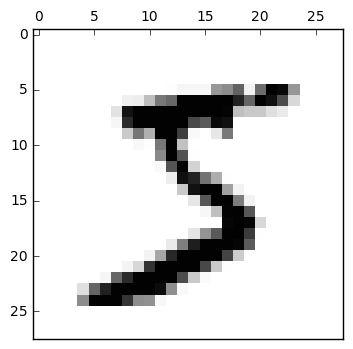

Image below should be a 0


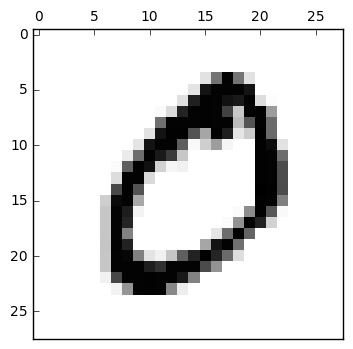

Image below should be a 4


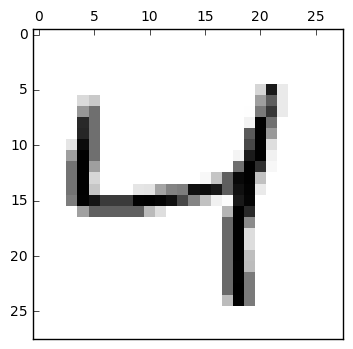

Image below should be a 1


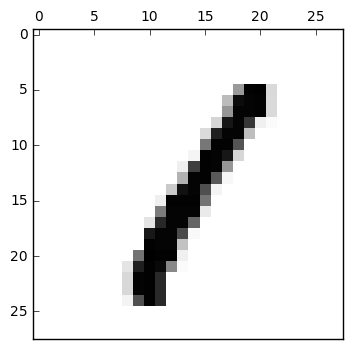

Image below should be a 9


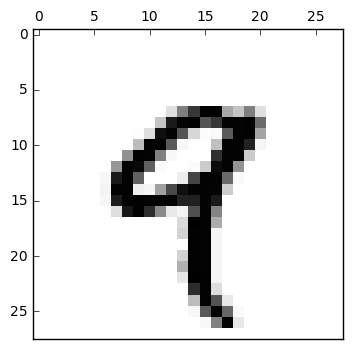

In [69]:
def show(image):
    """
    Render a given numpy.uint8 2D array of pixel data.
    """
    fig = plt.figure()
    ax = fig.add_subplot(1,1,1)
    imgplot = ax.imshow(image, cmap=mpl.cm.Greys)
    imgplot.set_interpolation('nearest')
    ax.xaxis.set_ticks_position('top')
    ax.yaxis.set_ticks_position('left')
    plt.show()

for i in xrange(5):
    print("Image below should be a", train_labels[i])
    show(train_images[i])

We need to create synthetic combinations of these images. Eg., up to five images combined at a time.

This section will create training and test sets of these synthetic sequences.

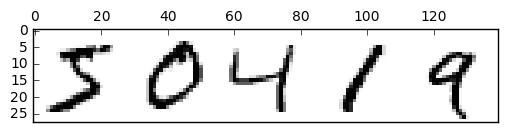

In [75]:
# Using numpy.hstack will stack together the pixel arrays to form synthetic sequences.
# Example:
show(np.hstack(train_images[:5]))

So we will need to create a random (but ideally reproducible) set of these sequences up to length 5.

We also need to fill the sequence to a length of five in cases where less than five digits are present. This can be done with a 28 x 28 array of zeros (all white), representing 'no digit'.

[[16196  3250 23538 56946  1352]
 [25759  1252 23568 34442 54907]
 [38422  6346 13367 16666 54872]]
The image below shows [2 7 4 4 9]


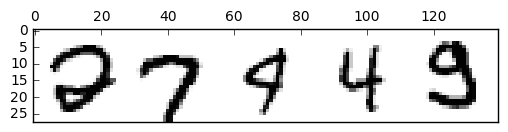

In [110]:
no_digit = np.zeros(train_images[0].shape)  # No-digit array

n_train_seq = 100000  # Number of training sequences to generate
n_test_seq  =  30000  # Number of test sequences to generate

np.random.seed(seed=387)  # To make reproducible
train_seq_n = np.random.randint(5, size=n_train_seq) + 1  # Number of digits in each training sequence
test_seq_n  = np.random.randint(5, size=n_test_seq) + 1   # Number of digits in each test sequence

train_seq = np.random.randint(len(train_images), size=[n_train_seq, 5])

    
# Need to add some 'blank' digits
print(train_seq[:3])

print ("The image below shows", train_labels[train_seq[0]])
show(np.hstack(train_images[train_seq[0]]))

### Question 1
_What approach did you take in coming up with a solution to this problem?_

**Answer:** 

### Question 2
_What does your final architecture look like? (Type of model, layers, sizes, connectivity, etc.)_

**Answer:**

### Question 3
_How did you train your model? How did you generate your synthetic dataset?_ Include examples of images from the synthetic data you constructed.

**Answer:**

----
## Step 2: Train a Model on a Realistic Dataset
Once you have settled on a good architecture, you can train your model on real data. In particular, the [Street View House Numbers (SVHN)](http://ufldl.stanford.edu/housenumbers/) dataset is a good large-scale dataset collected from house numbers in Google Street View. Training on this more challenging dataset, where the digits are not neatly lined-up and have various skews, fonts and colors, likely means you have to do some hyperparameter exploration to perform well.

### Implementation
Use the code cell (or multiple code cells, if necessary) to implement the first step of your project. Once you have completed your implementation and are satisfied with the results, be sure to thoroughly answer the questions that follow.

In [ ]:


### Your code implementation goes here.
### Feel free to use as many code cells as needed.



### Question 4
_Describe how you set up the training and testing data for your model. How does the model perform on a realistic dataset?_

**Answer:**

### Question 5
_What changes did you have to make, if any, to achieve "good" results? Were there any options you explored that made the results worse?_

**Answer:**

### Question 6
_What were your initial and final results with testing on a realistic dataset? Do you believe your model is doing a good enough job at classifying numbers correctly?_

**Answer:**

----
## Step 3: Test a Model on Newly-Captured Images

Take several pictures of numbers that you find around you (at least five), and run them through your classifier on your computer to produce example results. Alternatively (optionally), you can try using OpenCV / SimpleCV / Pygame to capture live images from a webcam and run those through your classifier.

### Implementation
Use the code cell (or multiple code cells, if necessary) to implement the first step of your project. Once you have completed your implementation and are satisfied with the results, be sure to thoroughly answer the questions that follow.

In [ ]:


### Your code implementation goes here.
### Feel free to use as many code cells as needed.



### Question 7
_Choose five candidate images of numbers you took from around you and provide them in the report. Are there any particular qualities of the image(s) that might make classification difficult?_

**Answer:**

### Question 8
_Is your model able to perform equally well on captured pictures or a live camera stream when compared to testing on the realistic dataset?_

**Answer:**

### Optional: Question 9
_If necessary, provide documentation for how an interface was built for your model to load and classify newly-acquired images._

**Answer:** Leave blank if you did not complete this part.

----
### Step 4: Explore an Improvement for a Model

There are many things you can do once you have the basic classifier in place. One example would be to also localize where the numbers are on the image. The SVHN dataset provides bounding boxes that you can tune to train a localizer. Train a regression loss to the coordinates of the bounding box, and then test it. 

### Implementation
Use the code cell (or multiple code cells, if necessary) to implement the first step of your project. Once you have completed your implementation and are satisfied with the results, be sure to thoroughly answer the questions that follow.

In [ ]:


### Your code implementation goes here.
### Feel free to use as many code cells as needed.



### Question 10
_How well does your model localize numbers on the testing set from the realistic dataset? Do your classification results change at all with localization included?_

**Answer:**

### Question 11
_Test the localization function on the images you captured in **Step 3**. Does the model accurately calculate a bounding box for the numbers in the images you found? If you did not use a graphical interface, you may need to investigate the bounding boxes by hand._ Provide an example of the localization created on a captured image.

**Answer:**

----
## Optional Step 5: Build an Application or Program for a Model
Take your project one step further. If you're interested, look to build an Android application or even a more robust Python program that can interface with input images and display the classified numbers and even the bounding boxes. You can for example try to build an augmented reality app by overlaying your answer on the image like the [Word Lens](https://en.wikipedia.org/wiki/Word_Lens) app does.

Loading a TensorFlow model into a camera app on Android is demonstrated in the [TensorFlow Android demo app](https://github.com/tensorflow/tensorflow/tree/master/tensorflow/examples/android), which you can simply modify.

If you decide to explore this optional route, be sure to document your interface and implementation, along with significant results you find. You can see the additional rubric items that you could be evaluated on by [following this link](https://review.udacity.com/#!/rubrics/413/view).

### Optional Implementation
Use the code cell (or multiple code cells, if necessary) to implement the first step of your project. Once you have completed your implementation and are satisfied with the results, be sure to thoroughly answer the questions that follow.

In [ ]:


### Your optional code implementation goes here.
### Feel free to use as many code cells as needed.



### Documentation
Provide additional documentation sufficient for detailing the implementation of the Android application or Python program for visualizing the classification of numbers in images. It should be clear how the program or application works. Demonstrations should be provided. 

_Write your documentation here._

> **Note**: Once you have completed all of the code implementations and successfully answered each question above, you may finalize your work by exporting the iPython Notebook as an HTML document. You can do this by using the menu above and navigating to  
**File -> Download as -> HTML (.html)**. Include the finished document along with this notebook as your submission.